### State of the Climate report 2023 

Author: Marcel du Plessis

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import pandas as pd

import tqdm.notebook as tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset
from functions.convert_era5_to_Wm2 import convert_era5_to_Wm2

In [3]:
ds = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/Data/ERA5/monthly_flux_2004_2022_ERA5.nc')

ds = ds.sum(dim='expver')

#### Convert the heat flux data from the J m-2 format that ERA5 provides to W m-2

In [4]:
from calendar import monthrange

swr = np.ndarray(ds.ssr.shape)
lwr = np.ndarray(ds.str.shape)
shf = np.ndarray(ds.sshf.shape)
lhf = np.ndarray(ds.slhf.shape)

for t in tqdm.tqdm(range(ds.time.size)):
    
    dat = ds.isel(time=t)

    year  = dat.time.dt.year
    month = dat.time.dt.month

    days_in_month = monthrange(int(year), int(month))[1]

    swr[t] = dat.ssr.data /  (3600 * days_in_month)
    lwr[t] = dat.str.data /  (3600 * days_in_month)
    shf[t] = dat.sshf.data / (3600 * days_in_month)
    lhf[t] = dat.slhf.data / (3600 * days_in_month)
    
ds['ssr'] = (('time', 'latitude', 'longitude'),  swr)
ds['str'] = (('time', 'latitude', 'longitude'),  lwr)
ds['sshf'] = (('time', 'latitude', 'longitude'), shf)
ds['slhf'] = (('time', 'latitude', 'longitude'), lhf)

ds['qnet'] = (('time', 'latitude', 'longitude'), ds.ssr.data + ds.str.data + ds.sshf.data + ds.slhf.data)

  0%|          | 0/228 [00:00<?, ?it/s]

In [5]:
lsm = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/Data/ERA5/land_sea_mask.nc')

lsm = lsm.sel(latitude=slice(0, -90), time='2018-12-19')

lsm = adjust_lon_xr_dataset(lsm, lon_name='longitude')

lsm['lsm'] = (('latitude', 'longitude'), np.abs(lsm.lsm.data - 1))

In [6]:
var = ['ssr', 'str', 'sshf', 'slhf', 'u10', 'v10']

for v in var:
    
    ds[v] = (('time', 'latitude', 'longitude'), ds[v].data * lsm.lsm.data)

In [7]:
# stf   = pd.read_csv('/Users/xduplm/Google Drive/My Drive/Data/Fronts/orsi_1995/stf.txt').iloc[:-1]
saf   = pd.read_csv('/Users/xduplm/Google Drive/My Drive/Data/Fronts/orsi_1995/saf.txt').iloc[:-1]
# pf    = pd.read_csv('/Users/xduplm/Google Drive/My Drive/Data/Fronts/orsi_1995/pf.txt').iloc[:-1]
# saccf = pd.read_csv('/Users/xduplm/Google Drive/My Drive/Data/Fronts/orsi_1995/saccf.txt').iloc[:-1]

In [8]:
lon_saf = np.ndarray([saf.size])
lat_saf = np.ndarray([saf.size])

for i in range(saf.size):
    
    lon_saf[i] = saf.iloc[i][0][:10]
    lat_saf[i] = saf.iloc[i][0][10:]

In [9]:
ds_yr = ds.groupby('time.year').mean('time')

In [10]:
ds_clim = ds_yr.sel(year=slice(2004, 2020)).mean(dim='year')

In [11]:
ds_2022 = ds_yr.sel(year=2022)

In [12]:
ds_anom = ds_2022 - ds_clim

In [13]:
path_to_figs = '/Users/xduplm/Google Drive/My Drive/Projects/2023_sotc_heat_fluxes/state-of-the-climate-heat-fluxes-2022/figs/'

In [14]:
font = {'size' : 10}
plt.rc('font', **font)

plt.rc('ytick.major', size=4)
plt.rc('xtick.major', size=4)
plt.rc('ytick.minor', size=4)
plt.rc('xtick.minor', size=4)

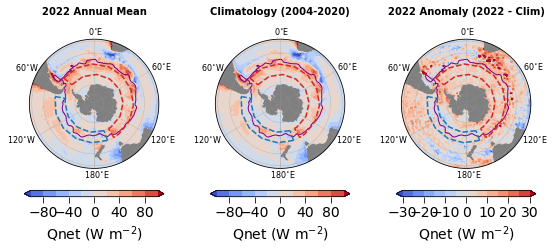

In [24]:
fig = plt.figure(figsize=[10, 3.5])

ax0 = fig.add_subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())

ax = [ax0, ax1, ax2]

props = dict(transform=ccrs.PlateCarree(), 
             cmap='coolwarm', 
             zorder=1, 
             extend='both', 
             cbar_kwargs={'orientation': 'horizontal', 
                          'pad'        : 0.06, 
                          'shrink'     : 0.75, 
                          'label'      : 'Qnet (W m$^{-2}$)'
                         }
            )

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
# We can pan/zoom as much as we like - the boundary will be permanently circular.
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.43
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax0.set_boundary(circle, transform=ax0.transAxes)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax2.set_boundary(circle, transform=ax2.transAxes)

fig.subplots_adjust(wspace=0)

ds_2022.qnet.plot.contourf(ax=ax0, **props, levels=np.arange(-100, 120, 20))
ds_clim.qnet.plot.contourf(ax=ax1, **props, levels=np.arange(-100, 120, 20))
ds_anom.qnet.plot.contourf(ax=ax2, **props, levels=np.arange(-30,   35,  5))

tls = ['2022 Annual Mean', 'Climatology (2004-2020)', '2022 Anomaly (2022 - Clim)']

for i, a in enumerate(ax):
    
    a.add_feature(cfeature.LAND, facecolor='0.5', zorder=2)
    a.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
    a.set_title(tls[i], fontsize=10, y=1.05, fontweight='bold')
    a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='0.6', alpha=0.5, zorder=5, linestyle='-')

    a.plot(lon_saf, lat_saf, transform=ccrs.PlateCarree(), c='purple', lw=1)
    
    box_props = dict(ls='--', zorder=100, transform=ccrs.PlateCarree())
    
    # atlantic / indian box
    
    # ai_xmin, ai_xmax =  70, 150
    # ai_ymin, ai_ymax = -52, -40
    
    ai_xmin, ai_xmax = -50, 150
    ai_ymin, ai_ymax = -60, -50
    
    a.plot([ai_xmin, ai_xmax], [ai_ymin, ai_ymin], **box_props, c='tab:red')
    a.plot([ai_xmin, ai_xmax], [ai_ymax, ai_ymax], **box_props, c='tab:red')
    
    a.plot([ai_xmin, ai_xmin], [ai_ymax, ai_ymin], **box_props, c='tab:red')
    a.plot([ai_xmax, ai_xmax], [ai_ymax, ai_ymin], **box_props, c='tab:red')
    
    # pacific box
    
    p_xmin, p_xmax = -200, -80
    p_ymin, p_ymax = -60, -50
    
    a.plot([p_xmin, p_xmax], [p_ymin, p_ymin], **box_props, c='tab:blue')
    a.plot([p_xmin, p_xmax], [p_ymax, p_ymax], **box_props, c='tab:blue')
    
    a.plot([p_xmin, p_xmin], [p_ymax, p_ymin], **box_props, c='tab:blue')
    a.plot([p_xmax, p_xmax], [p_ymax, p_ymin], **box_props, c='tab:blue')
    
    a.text(-5,    -25, '0$^{\circ}$E',   transform=ccrs.PlateCarree(), fontsize=8)
    a.text(60,    -27, '60$^{\circ}$E',  transform=ccrs.PlateCarree(), fontsize=8)
    a.text(125,   -25, '120$^{\circ}$E', transform=ccrs.PlateCarree(), fontsize=8)
    a.text(-172,  -20, '180$^{\circ}$E', transform=ccrs.PlateCarree(), fontsize=8)
    a.text(-67.5, -13, '60$^{\circ}$W',  transform=ccrs.PlateCarree(), fontsize=8)
    a.text(-114.3, -7,  '120$^{\circ}$W', transform=ccrs.PlateCarree(), fontsize=8)

    
plt.savefig(path_to_figs + 'map_2022_vs_clim_era5.pdf', dpi=300)

In the Pacific, the southwawrd migration of the ACC under the conservations of barotropic PV has large impacts for the heat fluxes. In the Pacific section, this means that the ACC experiences cooler shortwave radiation, as well as cooler and drier air, meaning a larger heat loss in this sector.

Mechanisms that may impact this is the migration latitude of the ACC, varying variability of air masses (Antarctic air in the Pacific vs Subtropical air in the Atlantic). 

In [16]:
ds_clim_month = ds.sel(time=slice('2004-01-01', '2020-12-31')).groupby('time.month').mean()
ds_2022_month = ds.sel(time=slice('2022-01-01', '2022-12-31')).groupby('time.month').mean()

In [17]:
ds_2022_box_ai = ds_2022_month.sel(latitude=slice(ai_ymax, ai_ymin), longitude=slice(ai_xmin, ai_xmax)).mean(dim=('latitude', 'longitude'))
# ds_2022_box_p  = ds_2022_month.sel(latitude=slice( p_ymax,  p_ymin), longitude=slice( p_xmin,  p_xmax)).mean(dim=('latitude', 'longitude'))

ds_clim_box_ai = ds_clim_month.sel(latitude=slice(ai_ymax, ai_ymin), longitude=slice(ai_xmin, ai_xmax)).mean(dim=('latitude', 'longitude'))
# ds_clim_box_p  = ds_clim_month.sel(latitude=slice( p_ymax,  p_ymin), longitude=slice( p_xmin,  p_xmax)).mean(dim=('latitude', 'longitude'))

In [18]:
lon_p = np.append(ds_clim_month.longitude[ds_clim_month.longitude < p_xmax], ds_clim_month.longitude[ds_clim_month.longitude > 160])

In [19]:
ds_2022_box_p  = ds_2022_month.sel(latitude=slice( p_ymax,  p_ymin), longitude=lon_p).mean(dim=('latitude', 'longitude'))
ds_clim_box_p  = ds_clim_month.sel(latitude=slice( p_ymax,  p_ymin), longitude=lon_p).mean(dim=('latitude', 'longitude'))

In [20]:
font = {'size' : 14}
plt.rc('font', **font)

plt.rc('ytick.major', size=6)
plt.rc('xtick.major', size=6)
plt.rc('ytick.minor', size=4)
plt.rc('xtick.minor', size=4)

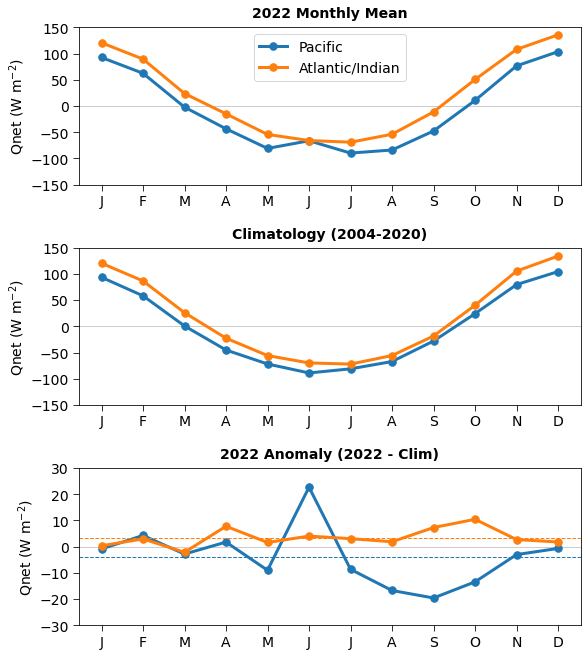

In [21]:
fig,ax=plt.subplots(nrows=3, ncols=1, figsize=(9, 11))

fig.subplots_adjust(hspace=0.4)

props = dict(lw=3, marker='.', ms=15)

ds_2022_box_p .qnet.plot(ax=ax[0], **props, label='Pacific')
ds_2022_box_ai.qnet.plot(ax=ax[0], **props, label='Atlantic/Indian')

ds_clim_box_p. qnet.plot(ax=ax[1], **props)
ds_clim_box_ai.qnet.plot(ax=ax[1], **props)

diff_p  = ds_2022_box_p  - ds_clim_box_p
diff_ai = ds_2022_box_ai - ds_clim_box_ai

diff_p. qnet.plot(ax=ax[2], **props)
diff_ai.qnet.plot(ax=ax[2], **props)

# for yr in np.arange(2004, 2021, 1):
    
#     dat_ai = ds.isel(time=ds.time.dt.year==yr).sel(latitude=slice(ai_ymax, ai_ymin), longitude=slice(ai_xmin, ai_xmax)).mean(dim=('latitude', 'longitude'))
#     dat_p  = ds.isel(time=ds.time.dt.year==yr).sel(latitude=slice(p_ymax, p_ymin),   longitude=slice(p_xmin, p_xmax)).  mean(dim=('latitude', 'longitude'))

#     ax[1].plot(np.arange(1, 13), dat_p .qnet, lw=0.7, c='tab:blue'  , zorder=0, alpha=0.5)
#     ax[1].plot(np.arange(1, 13), dat_ai.qnet, lw=0.7, c='tab:orange', zorder=0, alpha=0.5)

    
t_props = dict( fontweight='bold', pad=10, fontsize=14)

ax[0].set_title('2022 Monthly Mean', **t_props)
ax[1].set_title('Climatology (2004-2020)', **t_props)
ax[2].set_title('2022 Anomaly (2022 - Clim)', **t_props)

ax[0].legend(loc='upper center')

ax[0].set_ylim(-150, 150)
ax[1].set_ylim(-150, 150)
ax[2].set_ylim(-30, 30)

for a in ax:
    
    a.axhline(zorder=0, lw=1, c='0.8')
    a.set_xlabel('')
    a.xaxis.set_ticks(np.arange(1, 13))
    a.xaxis.set_ticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    a.set_ylabel('Qnet (W m$^{-2}$)')
    
ax[0].yaxis.set_ticks(np.arange(-150, 200, 50))
ax[1].yaxis.set_ticks(np.arange(-150, 200, 50))
ax[2].yaxis.set_ticks(np.arange(-30,   40, 10))

ax[2].axhline(y=diff_p.qnet.mean(dim='month'),  c='tab:blue'  , lw=1, ls='--')
ax[2].axhline(y=diff_ai.qnet.mean(dim='month'), c='tab:orange', lw=1, ls='--')

plt.savefig(path_to_figs + 'sector_compare.png', dpi=300)

In [22]:
print((ds_2022_box_p.qnet).mean())
print((ds_2022_box_ai.qnet).mean())

<xarray.DataArray 'qnet' ()>
array(-5.66478209)
<xarray.DataArray 'qnet' ()>
array(21.60699213)


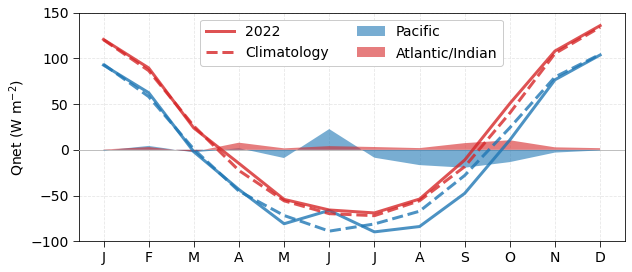

In [25]:
fig,ax=plt.subplots(ncols=1, nrows=1, figsize=(9, 4))

ai_color = 'tab:red'
p_color  = 'tab:blue'

props_clim = dict(lw=3, alpha=0.8, zorder=20, marker='.', ms=0, ls='--')
props_2022 = dict(lw=3, alpha=0.8, zorder=20, marker='^', ms=0)

ds_2022_box_p .qnet.plot(ax=ax, **props_2022, c=p_color )
ds_2022_box_ai.qnet.plot(ax=ax, **props_2022, c=ai_color, label='2022')

ds_clim_box_p .qnet.plot(ax=ax, **props_clim, c=p_color )
ds_clim_box_ai.qnet.plot(ax=ax, **props_clim, c=ai_color, label='Climatology')


ax.grid(ls='--', zorder=0, c='0.9')
ax.axhline(y=0, zorder=10, c='0.75', lw=1)
ax.set_xlabel('')
ax.xaxis.set_ticks(np.arange(1, 13))
ax.xaxis.set_ticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    
ax.set_ylim(-100, 150)

ax.yaxis.set_ticks(np.arange(-100, 200, 50))

ax.set_ylabel('Qnet (W m$^{-2}$)')

ax.fill_between(x=diff_p.month,  y1=0, y2=diff_p.qnet,  facecolor=p_color,  zorder=15, alpha=0.6, lw=0, label='Pacific')
ax.fill_between(x=diff_ai.month, y1=0, y2=diff_ai.qnet, facecolor=ai_color, zorder=15, alpha=0.6, lw=0, label='Atlantic/Indian')

ax.legend(ncol=2, fontsize=14, loc='upper center', framealpha=1)

fig.tight_layout()

plt.savefig(path_to_figs + 'sector_compare_v2.pdf', dpi=300)

In [30]:
diff_ai.qnet.std()

<xarray.DataArray 'qnet' ()>
array(3.33029382)

### Read in the SOFS data provided by Eric Shulz

In [146]:
sofs_qnet_2022 = np.array([225.2674, 121.1452, 57.1434, np.NaN, -94.4097, -133.5929, -76.9922, -63.8103, 12.5575, 79.2903, 117.5139, 180.5341])
sofs_n_obs = np.array([241, 239, 196, 0, 424, 503, 547, 550, 544, 504, 545, 581])

In [183]:
import pandas as pd
import datetime

sofs = pd.read_csv('../data/SOFS_HNET_2022', sep='\s+', names=['year', 'month', 'day', 'hour', 'minute', 'second', 'qnet'])

sofs_time = [np.datetime64(datetime.datetime(int(sofs.year[i]), int(sofs.month[i]), int(sofs.day[i]), int(sofs.hour[i]))) for i in range(sofs.year.size)]
sofs_time = np.array(sofs_time)

sofs['time'] = sofs_time

sofs = sofs.to_xarray().swap_dims({'index': 'time'}).drop(['index'])

In [148]:
sofs_1H = sofs.resample(time='1H').mean()

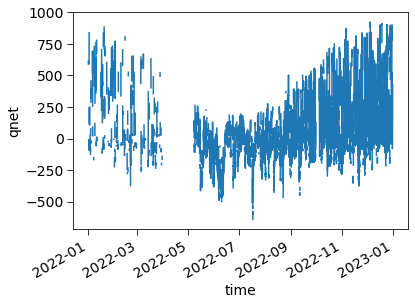

In [99]:
sofs_1H.qnet.plot()

In [102]:
# Our data set 

decorr = np.ndarray([11, 48])

for i, m in enumerate(np.unique(sofs.month.data)):
    
    data = sofs.isel(time=sofs.month==m).qnet.data

    acf = np.correlate(data - np.nanmean(data), data - np.nanmean(data), mode='full')[len(data) - 1:]

    acf /= acf[0]
    
    decorr[i] = acf[:48]

# plt.plot(acf[:48])

In [184]:
sofs_month_mean = np.ndarray([np.unique(sofs.month).size])
sofs_month_std_dev = np.ndarray([np.unique(sofs.month).size])

for i, m in enumerate(np.unique(sofs.month)):
    
    sofs_month_mean[i] = sofs.isel(time=sofs.month==m).groupby('time.hour').mean().qnet.mean()
    sofs_month_std_dev[i] = sofs.isel(time=sofs.month==m).groupby('time.hour').mean().qnet.std()
    

In [185]:
# fig,ax = plt.subplots(figsize=(11,5))

# img=ax.pcolormesh(np.arange(24), np.arange(12), sofs_month_mean, vmin=-600, vmax=600, cmap='RdBu_r')

# ax.yaxis.set_ticks(np.arange(12))
# ax.yaxis.set_ticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

# plt.colorbar(img)

# ax.xaxis.set_ticks(np.arange(24))

In [186]:
print(np.round(sofs_month_mean, 2))
print(np.round(sofs_qnet_2022, 2))

[ 184.97  112.78   58.86  -95.43 -134.96  -76.93  -61.69   11.93   81.25
  115.17  176.47]
[ 225.27  121.15   57.14     nan  -94.41 -133.59  -76.99  -63.81   12.56
   79.29  117.51  180.53]


In [187]:
sofs_month_mean    = np.append(sofs_month_mean, np.NaN)
sofs_month_std_dev = np.append(sofs_month_std_dev, np.NaN)

mth = np.append(sofs_month_avg.month.data, 4)

idx_sort = np.argsort(mth)

sofs_month_mean    = sofs_month_mean   [idx_sort]
sofs_month_std_dev = sofs_month_std_dev[idx_sort]

In [188]:
sofs_month_avg = sofs.groupby('time.month').mean('time')
sofs_month_std = sofs.groupby('time.month').std('time')

In [189]:
n_obs = [sofs.isel(time=sofs.month==i).qnet.size for i in range(1, 13)]

In [190]:
n_obs

[241, 239, 196, 0, 424, 503, 547, 550, 544, 504, 545, 581]

In [215]:
sofs_month_std_err = sofs_month_std_dev / np.sqrt(24)

In [216]:
sofs_month_std_err

array([53.05982758, 47.69515638, 44.54459693,         nan, 15.73485305,
       13.43030419, 13.50503494, 22.16726604, 32.28354484, 45.39923704,
       50.04950504, 53.0802008 ])

In [191]:
sofs_month_avg = sofs_month_avg.drop(['year', 'day', 'hour', 'minute', 'second'])
sofs_month_std = sofs_month_std.drop(['year', 'day', 'hour', 'minute', 'second'])

In [192]:
avg = np.append(sofs_month_avg.qnet.data, np.NaN)
std = np.append(sofs_month_std.qnet.data, np.NaN)
mth = np.append(sofs_month_avg.month.data, 4)

idx_sort = np.argsort(mth)

avg = avg[idx_sort]
std = std[idx_sort]
mth = mth[idx_sort]

In [193]:
sofs = xr.Dataset(

    data_vars=dict(

        qnet_average=(['month'], avg),

        qnet_std_dev=(['month'], std),
        
        number_obs  =(['month'], n_obs),
        
        qnet_std_err=(['month'], std/np.sqrt(n_obs)),

    ),

    coords=dict(

        month=mth

    ),

    attrs=dict(description="SOFS monthly mean and standard deviation for 2022 in W m$^{-2}$."),

)

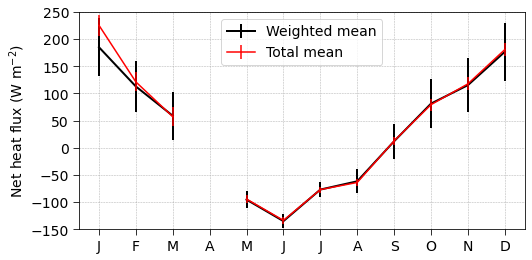

In [233]:
fig,ax = plt.subplots(figsize=(8, 4))

ax.errorbar(
    x = sofs.month, 
    y = sofs_month_mean,
    yerr = sofs_month_std_err,
    c='k', lw=2, label='Weighted mean'
)

ax.errorbar(
    x = sofs.month, 
    y = sofs.qnet_average,
    yerr = sofs.qnet_std_err, 
    c='r', lw=1.5, label='Total mean', zorder=100
)

ax.legend()

ax.set_ylim(-150, 250)

ax.xaxis.set_ticks(np.arange(1, 13))
ax.xaxis.set_ticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

ax.grid(lw=0.5, ls='--')

ax.yaxis.set_ticks(np.arange(-150, 300, 50))

ax.set_ylabel('Net heat flux (W m$^{-2}$)')

plt.savefig(path_to_figs + 'mean_calc_compare.png', dpi=300)

### ERA5 at the SOFS location

In [36]:
lon_idx = np.argmin(np.abs(ds.longitude.data - 140))
lat_idx = np.argmin(np.abs(ds.latitude.data - -46.8))

ds_sofs_era5 = ds.isel(latitude=int(lat_idx), longitude=int(lon_idx))

ds_sofs_era5_2022 = ds_sofs_era5.sel(time=slice('2022-01-01', '2022-12-31'))
ds_sofs_era5_clim = ds_sofs_era5.sel(time=slice('2004-01-01', '2020-12-31')).groupby('time.month').mean()

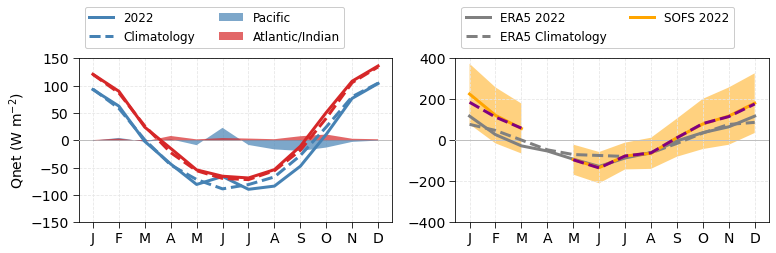

In [40]:
fig,ax=plt.subplots(ncols=2, nrows=1, figsize=(11, 4))

props = dict(lw=3, marker='.', ms=0, zorder=20)

ds_2022_box_p .qnet.plot(ax=ax[0], **props, c='steelblue', label='2022')
ds_2022_box_ai.qnet.plot(ax=ax[0], **props, c='tab:red')

ds_clim_box_p .qnet.plot(ax=ax[0], **props, c='steelblue', ls='--', label='Climatology')
ds_clim_box_ai.qnet.plot(ax=ax[0], **props, c='tab:red',   ls='--')

for a in ax:
    a.grid(ls='--', zorder=0, c='0.9')
    a.axhline(y=0, zorder=10, c='0.75', lw=1)
    a.set_xlabel('')
    a.xaxis.set_ticks(np.arange(1, 13))
    a.xaxis.set_ticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    
ax[0].set_ylim(-150, 150)
ax[1].set_ylim(-400, 400)

ax[0].yaxis.set_ticks(np.arange(-150, 200, 50))


ax[0].set_ylabel('Qnet (W m$^{-2}$)')

ax[0].fill_between(x=diff_p.month, y1=0, y2=diff_p.qnet, facecolor='steelblue', zorder=15, alpha=0.7, lw=0, label='Pacific')
ax[0].fill_between(x=diff_ai.month, y1=0, y2=diff_ai.qnet, facecolor='tab:red', zorder=15, alpha=0.7, lw=0, label='Atlantic/Indian')


ax[1].plot(np.arange(1, 13), ds_sofs_era5_2022.qnet, c='grey', lw=3, zorder=10, label='ERA5 2022') 
ax[1].plot(np.arange(1, 13), ds_sofs_era5_clim.qnet, c='grey', lw=3, zorder=10, label='ERA5 Climatology', ls='--')
ax[1].plot(np.arange(1, 13), sofs_qnet_2022, c='orange', lw=3, zorder=10, label='SOFS 2022')

ax[1].fill_between(x  = sofs.month, 
                   y1 = sofs.qnet_average + sofs.qnet_std_dev/2, 
                   y2 = sofs.qnet_average - sofs.qnet_std_dev/2,
                   facecolor='orange', alpha=0.5
                  )

# ax[1].errorbar(
    
#     x = sofs.month, 
#     y = sofs.qnet_average,
#     yerr = sofs.qnet_std_err,
#     lw=3, c='orange'

# )

ax[0].legend(ncol=2, fontsize=12, loc=2, bbox_to_anchor=(0, 1.35), framealpha=1)
ax[1].legend(ncol=2, fontsize=12, loc=2, bbox_to_anchor=(0, 1.35), framealpha=1)

ax[1].plot(sofs.month, sofs_month_mean, lw=3, c='purple', zorder=10, ls='--', label='Daily mean')

fig.tight_layout()

plt.savefig(path_to_figs + 'sofs_compare_std_dev.png', dpi=300)

In [63]:
sofs

<xarray.Dataset>
Dimensions:       (month: 12)
Coordinates:
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    qnet_average  (month) float64 225.3 121.1 57.14 nan ... 79.29 117.5 180.5
    qnet_std_dev  (month) float64 294.9 272.8 243.4 nan ... 244.7 279.2 290.8
    number_obs    (month) int64 241 239 196 0 424 503 547 550 544 504 545 581
    qnet_std_err  (month) float64 18.99 17.64 17.39 nan ... 10.9 11.96 12.06
Attributes:
    description:  SOFS monthly mean and standard deviation for 2022 in W m$^{...

In [104]:
(ds.n_obs/ds.n_obs.sum()).sum()

<xarray.DataArray 'n_obs' ()>
array(1.)

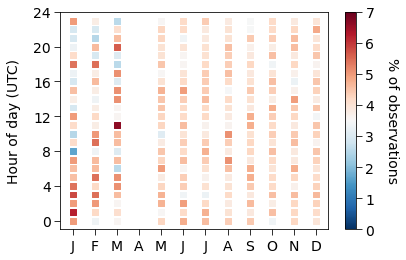

In [146]:
fig,ax=plt.subplots(figsize=(6,4))

for i in range(1, 13):
    
    try:

        ds = sofs.isel(time=sofs.month==i)
        
        ds['n_obs'] = (('time'), np.ones(ds.time.size))
        
        ds = ds.groupby('time.hour').sum()
        
        img = ax.scatter(np.zeros(ds.hour.size)+i, ds.hour, s=35, marker='s', c=100 * ds.n_obs/ds.n_obs.sum(), vmin=0, vmax=7, cmap='RdBu_r')
        
    except:
        
        continue
        
ax.xaxis.set_ticks(np.arange(1,13))
ax.xaxis.set_ticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

ax.yaxis.set_ticks(np.arange(0, 28, 4))
ax.set_ylim(-1, 24)

ax.set_ylabel('Hour of day (UTC)', labelpad=12)

cb=plt.colorbar(img)
cb.set_label('% of observations', rotation=-90, labelpad=25)

plt.savefig(path_to_figs + 'percent_obs_time_day.png', dpi=300)

In [75]:
ds

<xarray.Dataset>
Dimensions:  (time: 241)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T01:00:00 ... 2022-01-31T23:00:00
Data variables:
    year     (time) float64 2.022e+03 2.022e+03 ... 2.022e+03 2.022e+03
    month    (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    day      (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 30.0 31.0 31.0 31.0 31.0
    hour     (time) float64 1.0 2.0 10.0 11.0 12.0 ... 7.0 11.0 12.0 21.0 23.0
    minute   (time) float64 59.0 59.0 59.0 59.0 59.0 ... 59.0 59.0 59.0 59.0
    second   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    qnet     (time) float64 610.9 590.3 -12.99 -23.51 ... -5.943 -195.3 51.73
    n_obs    (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

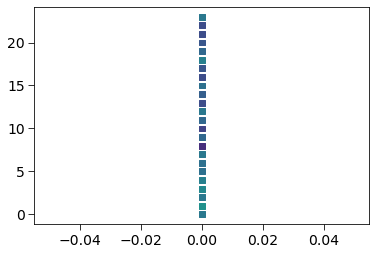